<a href="https://colab.research.google.com/github/aleksandr-del/gradient-boosting-from-scratch/blob/main/graident_boosting_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Градиентный бустинг для регрессии

Импортируем необходимые библиотеки, модули, функции:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

## Датасет

[Создаем игрушечный датасет](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html#sklearn.datasets.make_regression):

In [ ]:
X, y = make_regression(n_samples=1000, n_features=10)

Упакуем все в датафрейм:

In [ ]:
df = pd.DataFrame(X)
df['y_true'] = y
df.head()

,0,1,2,3,4,5,6,7,8,9,y_true
0,0.190191,0.102131,-0.727650,1.326866,0.956277,0.393419,-0.619942,1.403972,0.031264,-0.076007,160.639800
1,0.802898,1.096480,0.374079,-0.491611,0.786126,-0.900230,0.172447,0.658444,-1.044540,1.214986,153.131733
2,0.028499,-0.116362,-0.599242,-0.221276,1.391569,0.613630,2.042259,0.320276,0.132714,0.755259,212.372696
3,-0.041174,-0.271762,-1.171254,0.623700,1.171006,-0.719854,0.315177,2.608597,-1.976576,0.299630,63.394716
4,1.370564,0.597851,0.124681,-0.471121,1.078215,0.530921,-0.279244,-0.142642,0.609977,-2.065229,84.049121


## Бустинг

### Шаг 1

Инициализируем модель градиентного бустинга - делаем констатнтное предсказание для всех наблюдений (среднее значение по выборке является лучшим предсказанием, если наша функция потерь - сумма квадратов ошибки):

In [ ]:
df['y_pred_0'] = df['y_true'].mean()

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,y_true,y_pred_0
0,-0.727269,0.022508,0.344120,-0.526625,-1.434693,2.497329,-0.583163,-0.141302,0.075710,-0.395560,91.128983,-12.627207
1,-0.475321,1.108667,-0.544382,-0.780676,1.145937,0.738124,0.113520,-0.830364,1.792665,0.492390,74.708608,-12.627207
2,-1.179770,0.330838,0.648259,-0.481635,0.626106,-0.276344,0.254040,-1.434950,-0.713848,0.126808,-214.070264,-12.627207
3,-0.561148,0.582951,-0.768002,0.877364,-0.114408,0.587512,-1.693695,1.073134,-0.178924,0.380995,64.443824,-12.627207
4,0.785531,-0.731873,0.049060,-0.389738,0.129809,-0.191763,-0.624931,-0.144405,-0.132586,-0.361413,-121.783189,-12.627207


Посчитаем метрики качества модели:

In [ ]:
print(f"R2: {r2_score(df['y_true'], df['y_pred_0'])}")
print(f"MSE: {mean_squared_error(df['y_true'], df['y_pred_0'])}")
print(f"MAE: {mean_absolute_error(df['y_true'], df['y_pred_0'])}")

R2: 0.0
MSE: 34118.90914751159
MAE: 147.12716423011196


### Шаг 2

Посчитаем остатки:

In [ ]:
df['residuals_0'] = df['y_true'] - df['y_pred_0']
df.head()

,0,1,2,3,4,5,6,7,8,9,y_true,y_pred_0,residuals_0
0,-0.727269,0.022508,0.344120,-0.526625,-1.434693,2.497329,-0.583163,-0.141302,0.075710,-0.395560,91.128983,-12.627207,103.756190
1,-0.475321,1.108667,-0.544382,-0.780676,1.145937,0.738124,0.113520,-0.830364,1.792665,0.492390,74.708608,-12.627207,87.335816
2,-1.179770,0.330838,0.648259,-0.481635,0.626106,-0.276344,0.254040,-1.434950,-0.713848,0.126808,-214.070264,-12.627207,-201.443056
3,-0.561148,0.582951,-0.768002,0.877364,-0.114408,0.587512,-1.693695,1.073134,-0.178924,0.380995,64.443824,-12.627207,77.071031
4,0.785531,-0.731873,0.049060,-0.389738,0.129809,-0.191763,-0.624931,-0.144405,-0.132586,-0.361413,-121.783189,-12.627207,-109.155982


### Шаг 3

Инициализируем алгоритм Дерево решений с максимальной глубиной, равной 1 (stump), то есть листов у нас будет 2:

In [ ]:
model_1 = DecisionTreeRegressor(max_leaf_nodes=2)

Обучаемся на остатках:

In [ ]:
model_1.fit(df[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]], df['residuals_0'])

DecisionTreeRegressor(max_leaf_nodes=2)

Делаем новое предсказание, суммировав предсказанные алгоритмом остатки, умноженные на скорость обучения, и первое предсказание, другими словами, мы компенсируем остатки:

In [ ]:
df['y_pred_1'] = model_1.predict(df[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]) * 0.1 + df['y_pred_0']

Визуализируем дерево:

[Text(0.5, 0.75, 'X[7] <= -0.466\nsquared_error = 34118.909\nsamples = 1000\nvalue = -0.0'),
 Text(0.25, 0.25, 'squared_error = 26985.13\nsamples = 322\nvalue = -119.508'),
 Text(0.75, 0.25, 'squared_error = 27502.513\nsamples = 678\nvalue = 56.758')]

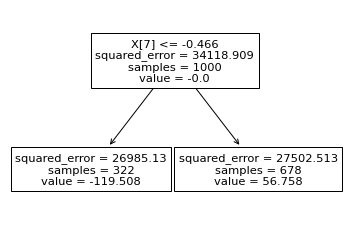

In [ ]:
plot_tree(model_1)

Посчитаем метрики качества:

In [ ]:
print(f"R2: {r2_score(df['y_true'], df['y_pred_1'])}")
print(f"MSE: {mean_squared_error(df['y_true'], df['y_pred_1'])}")
print(f"MAE: {mean_absolute_error(df['y_true'], df['y_pred_1'])}")

R2: 0.0377728609181488
MSE: 32830.14033760368
MAE: 143.9675828976416


### Шаг 4

Повторяем шаги 2, 3 до тех пор, пока не добьемся приемлемого качества или определенное количество деревьев. Напишем для этого функцию.

 Создадим копию исходного датафрейма:

In [ ]:
df = df[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'y_true']].copy()
df.head()

,0,1,2,3,4,5,6,7,8,9,y_true
0,0.190191,0.102131,-0.727650,1.326866,0.956277,0.393419,-0.619942,1.403972,0.031264,-0.076007,160.639800
1,0.802898,1.096480,0.374079,-0.491611,0.786126,-0.900230,0.172447,0.658444,-1.044540,1.214986,153.131733
2,0.028499,-0.116362,-0.599242,-0.221276,1.391569,0.613630,2.042259,0.320276,0.132714,0.755259,212.372696
3,-0.041174,-0.271762,-1.171254,0.623700,1.171006,-0.719854,0.315177,2.608597,-1.976576,0.299630,63.394716
4,1.370564,0.597851,0.124681,-0.471121,1.078215,0.530921,-0.279244,-0.142642,0.609977,-2.065229,84.049121


Создадим функцию:

In [ ]:
def gradient_boost(df, lr=0.01, iters=100, max_leaf_nodes=2):
    X = df.drop(columns='y_true').columns
    df['y_pred'] = df['y_true'].mean()
    models = []
    r2 = []
    MSE = []
    MAE = []
    
    for i in range(iters):
        df['residual'] = df['y_true'] - df['y_pred']
        model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes)
        model.fit(df[X], df['residual'])
        df['y_pred'] += model.predict(df[X]) * lr
        models.append(model)
        r2.append(r2_score(df['y_true'], df['y_pred']))
        MSE.append(mean_squared_error(df['y_true'], df['y_pred']))
        MAE.append(mean_absolute_error(df['y_true'], df['y_pred']))
    
    return models, r2, MSE, MAE 

Запустим градиентный бустинг с 1 000 деревьев-пеньков:

In [ ]:
models, r2, MSE, MAE = gradient_boost(df, iters=1000)

Визуализуем, как улучшались метрики качества с каждой последующей итерацией:

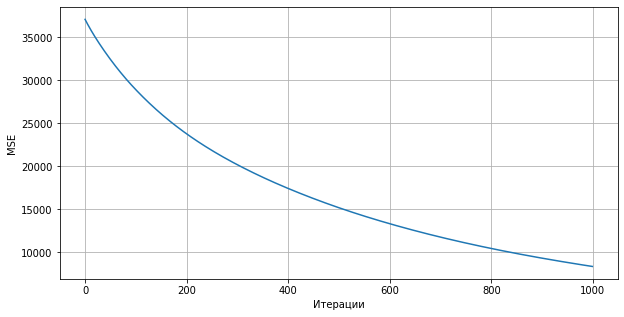

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(MSE)
plt.grid(True)
plt.ylabel('MSE')
plt.xlabel('Итерации')
plt.show()

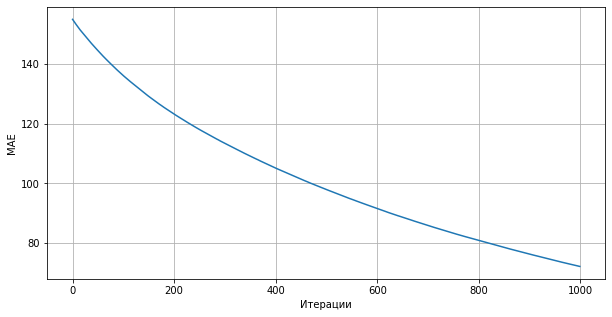

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(MAE)
plt.grid(True)
plt.ylabel('MAE')
plt.xlabel('Итерации')
plt.show()

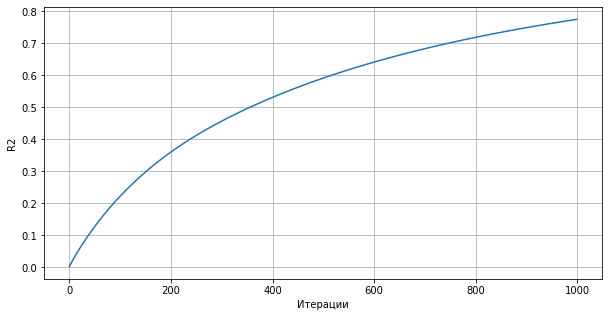

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(r2)
plt.grid(True)
plt.ylabel('R2')
plt.xlabel('Итерации')
plt.show()

## Обучение и тестирование модели

Задача: предсказать длину плавника по массе тела и длине клюва

Загрузим датасет пингвинов:

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI Start/Datasets/penguins.csv')
df.head(5)

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


Переведем признаки на русский язык:

In [ ]:
df.columns = ['вид','остров', 'длина клюва', 
              'ширина клюва', 'длина плавника', 
              'масса тела', 'пол']

Удалим строки с пропущенными значениями в признаках:

In [ ]:
df = df.dropna().reset_index(drop=True)

В таблице оставим только признаки `масса тела`, `длина клюва`, `длина плавника`, переименуем целевой признак в `y_true`:

In [ ]:
df = df[['масса тела', 'длина клюва', 'длина плавника']]

In [ ]:
df.columns = ['масса тела', 'длина клюва', 'y_true']

Поделим выборку на обучающую и тестовую:

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.25, random_state=42)

Обучим модель на обучающей выборке, в каждом дереве количество листов будет равно 2:

In [ ]:
models, r2, MSE, MAE = gradient_boost(df_train, 
                                      iters=1000,
                                      max_leaf_nodes=2)

Проверим модель на тестовой выборке:

In [ ]:
df_test['y_pred'] = df_train['y_true'].mean()

for model in models:
    df_test['y_pred'] += model.predict(df_test[['масса тела', 'длина клюва']]) * 0.01

Проверим метрики качества модели на тестовой выборке:

In [ ]:
print(f"R2: {r2_score(df_test['y_true'], df_test['y_pred'])}")
print(f"MSE: {mean_squared_error(df_test['y_true'], df_test['y_pred'])}")
print(f"MAE: {mean_absolute_error(df_test['y_true'], df_test['y_pred'])}")

R2: 0.8109899705470738
MSE: 39.41984173792637
MAE: 4.818773481514978


Сравним градиентный бустинг с классической линейной регрессией:

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(df_train[['масса тела', 'длина клюва']], df_train['y_true'])

LinearRegression()

In [ ]:
df_test['y_pred_lr'] = lr.predict(df_test[['масса тела', 'длина клюва']])

In [ ]:
print(f"R2: {r2_score(df_test['y_true'], df_test['y_pred_lr'])}")
print(f"MSE: {mean_squared_error(df_test['y_true'], df_test['y_pred_lr'])}")
print(f"MAE: {mean_absolute_error(df_test['y_true'], df_test['y_pred_lr'])}")

R2: 0.7832691227158404
MSE: 45.20128856120467
MAE: 5.37854803176602
